<a href="https://colab.research.google.com/github/jcandane/RTHF/blob/main/RTMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyscf 
#!git clone https://github.com/jcandane/RTHF_DensityMatrix
!git clone https://github.com/jcandane/Lightfield

fatal: destination path 'Lightfield' already exists and is not an empty directory.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf import scf, gto
from tqdm import tqdm
from Lightfield.lightfield import lightfield

plt.style.use("dark_background")

In [3]:
def Expm_(A):
    Eigenvalues, Eigenvectors = np.linalg.eig( A[0] )
    A1 = Eigenvectors @  np.diag(  np.exp( Eigenvalues)  )  @ np.linalg.inv(Eigenvectors)
    Eigenvalues, Eigenvectors = np.linalg.eig( A[1] )
    A2 = Eigenvectors @  np.diag(  np.exp( Eigenvalues)  )  @ np.linalg.inv(Eigenvectors)
    return np.array([A1, A2])

def getAO(D, C):
    ## transform MO density into an AO density 
    return np.array([ C[0] @ D[0] @ (C[0].T), C[1] @ D[1] @ (C[1].T) ])

def getMO(F, C):
    ## transform AO Fock into an MO Fock 
    return np.array([ (C[0].T) @ F[0] @ C[0] , (C[1].T) @ F[1] @ C[1] ])

def getF(D, H1, H2):
    ## get AO-Fock Matrix
    J  = np.sum(H2*(D[0]+D[1]), axis=(2,3))
    Fα = H1 + J - np.sum(H2.swapaxes(1,2)*D[0], axis=(2,3))
    Fβ = H1 + J - np.sum(H2.swapaxes(1,2)*D[1], axis=(2,3))
    return np.array([ Fα, Fβ ])

def getΣ(D, H2):
    if len(D[0]) == 0:
        return 0.
    ## get AO-Fock Matrix
    else:
        J  = np.sum(H2*(D[0]+D[1]), axis=(2,3))
        J *= 2
        J -= np.sum(H2.swapaxes(1,2)*D[0], axis=(2,3))
        J -= np.sum(H2.swapaxes(1,2)*D[1], axis=(2,3))
        return J

###########################

def UnitaryIntStep(D_in, C, H0_1, H0_2, ht_int, dt):
    """
    Unitary Integration Step in AO Basis
    """

    D_ao  = getAO(D_in, C)
    F_ao  = getF(D_ao, H0_1, H0_2) - ht_int
    F_mo  = getMO(F_ao, C) 
    U     = Expm_( -1j*(dt)*F_mo )
    D_out = np.array([ U[0] @ D_in[0] @ (U[0].conj().T), U[1] @ D_in[1] @ (U[1].conj().T) ])

    trace = np.trace(D_out[0].real + D_out[1].real)
    Eng   = np.trace((H0_1 + F_ao[0]) @ D_ao[0]/2).real + np.trace((H0_1 + F_ao[1]) @ (D_ao[1]/2)).real

    return D_out, D_ao, Eng, trace

def UnitaryIntStepMO(D_in, C, H0_1, H0_2, ht_int, dt):
    """
    Unitary Integration Step in MO Basis
    """

    F_mo  = H0_1 + np.einsum("STpqrs, Trs -> Spq", H0_2, D_in) - ht_int
    U     = Expm_( -1j*(dt)*F_mo )
    D_out = np.array([ U[0] @ D_in[0] @ (U[0].conj().T), U[1] @ D_in[1] @ (U[1].conj().T) ])

    trace = np.trace(D_out[0].real + D_out[1].real)
    Eng   = np.trace((H0_1 + F_mo)[0] @ D_out[0]/2).real + np.trace((H0_1 + F_mo)[1] @ (D_out[1]/2)).real

    return D_out, Eng, trace

######### define Light-Matter Interaction
def h_int(coupling, field):
    return coupling[0]*field[0] + coupling[1]*field[1] + coupling[2]*field[2]

def couple(scf):
    """
    GIVEN: scf
    GET:   MO-representation of Coupling
    """
    C = np.asarray((scf).mo_coeff)
    d = (scf.mol).intor("int1e_r")
    return np.array([ getMO(d[0], C), getMO(d[1], C), getMO(d[2], C) ])

def coup_time(D_t, coupling):
    return None
#########

def RTMF_numpy(D_in, C, H0_1, H0_2, E_t, dipole, dt):

    tsteps = len(E_t)
    D_t    = np.zeros((tsteps, 2, len(D_in[0]), len(D_in[0])), dtype=np.complex128)
    Davg   = np.zeros((2, len(C[0]), len(C[0])), dtype=np.complex128)
    energy = np.zeros(tsteps)
    trace  = np.zeros(tsteps)
    for step in tqdm(range(tsteps)):
        ht_int = h_int(dipole, E_t[step])
        D_out, D_ao, Eng, tr = UnitaryIntStep(D_in, C, H0_1, H0_2, ht_int, dt)

        #### probe
        D_t[step]    = D_out
        Davg        += D_ao
        energy[step] = Eng
        trace[step]  = tr

        D_in = D_out

    Davg *= 1/tsteps
    return D_t, Davg, energy, trace

def RTMF(D_in, field, couple, scf, interact_time_average=False):
    """
    GIVEN:  dt (electronic time-step), 
            dT (nuclei time-step), 
            D (initial MO density-matrix 3D numpy D_spq ),
            uhf_pyscf (uhf class)
            field (2D numpy array representing real-time electric-field)
    GET:    d_tx: dynamic dipole
            energy: energy of system in time
            trace: trace of MO density matrix in time
            Dao: AO current
    """

    C      = np.asarray((scf).mo_coeff)
    dipole = (scf.mol).intor("int1e_r")
    H0_1   = (scf.mol).intor("int1e_kin")
    H0_1  += (scf.mol).intor("int1e_nuc")
    H0_2   = (scf.mol).intor("int2e") ###!! dont calculate!!

    E_t, E_w = field.get_E()
    dt = field.dt

    D_t, D_ao, energy, trace = RTMF_numpy(D_in, C, H0_1, H0_2, E_t, dipole, dt)

    if interact_time_average:
        d_sxAB = np.einsum("xAB, sAp, sBq -> sxpq", dipole, C, C)
        d_tx   = np.einsum("sxpq, tspq -> tx", d_sxAB, D_t)
        d_tx  -= np.einsum("tx -> x", d_tx)/len(d_tx)
        t = field.t
        ω = field.ω
        d_ωx = field.fft(d_tx)
        return t, d_tx, ω, d_ωx, D_t, D_ao, energy, trace
    else:
        return D_t, D_ao, energy, trace

### define Lightfield

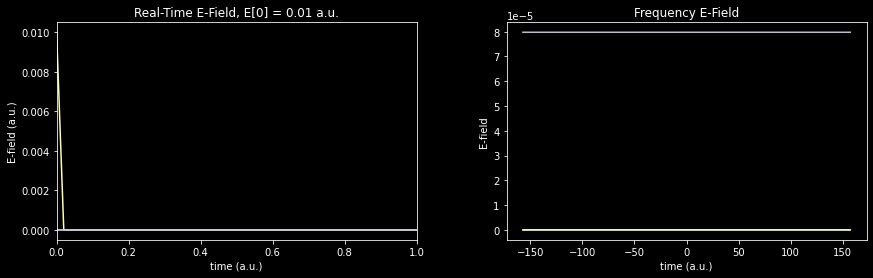

In [4]:
field3 = lightfield()
field3.E0 = -1e-2
field3.w  = 0.25
field3.Γ  = 0.01
field3.dt = 0.02
field3.T  = 100
field3.k  = np.array([0.,0.,1.])
E_t, E_w = field3.get_E()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.subplots_adjust(hspace=0.01, wspace=0.25, right=2)

ax1.plot(field3.t, E_t )
ax1.set_xlim(0, 1)
ax1.set_title("Real-Time E-Field, E[0] = " + str(np.linalg.norm(E_t[0])) + " a.u." )
ax1.set(xlabel='time (a.u.)', ylabel='E-field (a.u.)')

ax2.plot(field3.ω, E_w)
ax2.set_title("Frequency E-Field")
ax2.set(xlabel='time (a.u.)', ylabel='E-field')

fig.show()

### define scf

In [5]:
### Molecule
mol = gto.M(atom="H 0.0 0.0 0.0; Li 1.6 0.0 0.0")
mol.basis = "sto-3g"
CoM = np.einsum("i, ix-> x", (mol).atom_mass_list(isotope_avg=True), (mol).atom_coords() ) / np.sum( (mol).atom_mass_list(isotope_avg=True) )
mol.set_common_orig_( CoM )

uhf = scf.UHF(mol)
uhf.conv_tol = 1e-14
uhf.kernel()

DA_mo, DB_mo = (uhf).mo_occ
D_in  = np.array([np.diag(DA_mo).astype(complex), np.diag(DB_mo).astype(complex) ])

converged SCF energy = -7.86186476980865  <S^2> = 1.110223e-15  2S+1 = 1


# RTMF

In [6]:
D_t, D_ao, energy, trace = RTMF(D_in, field3, couple, uhf, interact_time_average=False)
t, d_tx, ω, d_ωx, D_t, D_ao, energy, trace = RTMF(D_in, field3, couple, uhf, interact_time_average=True)

100%|██████████| 5000/5000 [00:10<00:00, 477.45it/s]


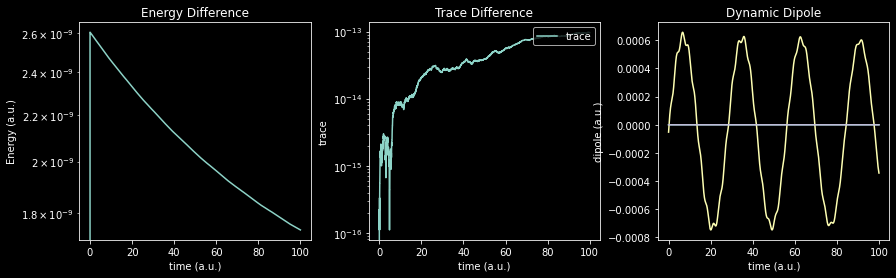

In [7]:
t = field3.t
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.subplots_adjust(hspace=0.01, wspace=0.25, right=2)

ax1.plot(t, np.abs(energy/energy[0]-1) )
ax1.set_yscale('log')
ax1.set_title("Energy Difference")
ax1.set(xlabel='time (a.u.)', ylabel='Energy (a.u.)')

ax2.plot(t, np.abs(trace/trace[0] -1), label="trace")
ax2.set_yscale('log')
ax2.legend(loc="upper right")
ax2.set_title("Trace Difference")
ax2.set(xlabel='time (a.u.)', ylabel='trace')

ax3.plot(t, d_tx.real )
ax3.set_title("Dynamic Dipole")
ax3.set(xlabel='time (a.u.)', ylabel='dipole (a.u.)')

fig.show()

#GAS-RTMF

In [8]:
def GAS_RTMF(D_in, field, couple, scf, ξ=None, interact_time_average=False):
    """
    GIVEN:  dt (electronic time-step), 
            dT (nuclei time-step), 
            D (initial MO density-matrix 3D numpy D_spq ),
            uhf_pyscf (uhf class)
            field (2D numpy array representing real-time electric-field)
    GET:    d_tx: dynamic dipole
            energy: energy of system in time
            trace: trace of MO density matrix in time
            Dao: AO current
    """
    
    C = np.asarray((scf).mo_coeff)
    if ξ is None:
        ξ  = np.arange(0, len(C[0]), 1, dtype=int)
    
    o = np.arange(0, len(D_in[0]), 1)
    χ = np.delete(o, ξ) 
    ξξ, xx = np.meshgrid(ξ, ξ)
    χχ, xx = np.meshgrid(χ, χ) ### grid
    
    C      = np.array([ C[0,:,ξ], C[1,:,ξ] ]).swapaxes(1,2) ##!!
    D_in   = np.array([ D_in[0,ξξ,ξξ.T], D_in[1,ξξ,ξξ.T] ])
    #D0_in  = np.array([ D_in[0,χχ,χχ.T], D_in[1,χχ,χχ.T] ]) ## trace this with ERI
    dipole = (scf.mol).intor("int1e_r")
    H0_1   = (scf.mol).intor("int1e_kin")
    H0_1  += (scf.mol).intor("int1e_nuc")
    H0_2   = (scf.mol).intor("int2e") ###!! dont calculate!!
    
    #H0_1 = H0_1.astype(np.complex128)
    #D0_in = getAO(D0_in, C)
    #Hgas  = getΣ(D0_in, H0_2)
    #H0_1 += Hgas

    E_t, E_w = field.get_E()
    dt = field.dt

    D_t, D_ao, energy, trace = RTMF_numpy(D_in, C, H0_1, H0_2, E_t, dipole, dt)

    if interact_time_average:
        d_sxAB = np.einsum("xAB, sAp, sBq -> sxpq", dipole, C, C)
        d_tx   = np.einsum("sxpq, tspq -> tx", d_sxAB, D_t)
        d_tx  -= np.einsum("tx -> x", d_tx)/len(d_tx)
        t = field.t
        ω = field.ω
        d_ωx = field.fft(d_tx)
        return t, d_tx, ω, d_ωx, D_t, D_ao, energy, trace
    else:
        return D_t, D_ao, energy, trace

t, d_tx, ω, d_ωx, D_t, D_ao, energy, trace = GAS_RTMF(D_in, field3, couple, uhf, ξ=np.array([0,1,2, 3]), interact_time_average=True)

100%|██████████| 5000/5000 [00:06<00:00, 769.83it/s] 


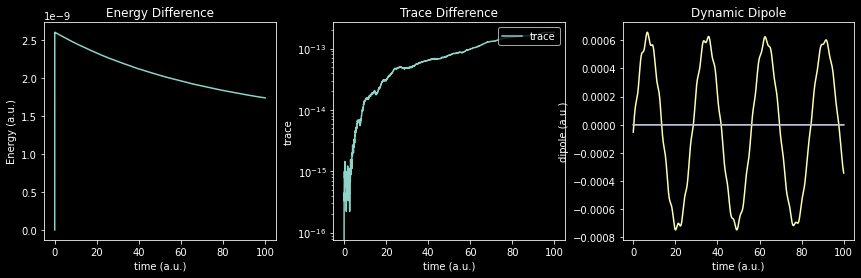

In [9]:
t = field3.t
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.subplots_adjust(hspace=0.01, wspace=0.25, right=2)

ax1.plot(t, np.abs(energy/energy[0]-1) )
#ax1.set_yscale('log')
ax1.set_title("Energy Difference")
ax1.set(xlabel='time (a.u.)', ylabel='Energy (a.u.)')

ax2.plot(t, np.abs(trace/trace[0] -1), label="trace")
ax2.set_yscale('log')
ax2.legend(loc="upper right")
ax2.set_title("Trace Difference")
ax2.set(xlabel='time (a.u.)', ylabel='trace')

ax3.plot(t, d_tx.real )
ax3.set_title("Dynamic Dipole")
ax3.set(xlabel='time (a.u.)', ylabel='dipole (a.u.)')

fig.show()

# Export to RTHF.py

In [10]:
!git clone https://github.com/jcandane/pyprototyp
from pyprototyp.pyprototyp import pyprototyp

pyprototyp("RTMF", packages=[], useful=[], defs=[Expm_, getAO, getMO, getF, RTMF, RTMF_numpy], classes=[])

fatal: destination path 'pyprototyp' already exists and is not an empty directory.


In [11]:
from pyscf import ao2mo

def get_SO_H1(H_ao, scf, ξ=None):
    C = np.asarray((scf).mo_coeff)
    if ξ is None:
          ξ  = np.arange(0, len(C[0]), 1, dtype=int)
    C = np.array([ C[0,:,ξ], C[1,:,ξ] ]).swapaxes(1,2)
    return np.array([ (C[0].T) @ H_ao @ C[0] , (C[1].T) @ H_ao @ C[1] ])
    #return np.asarray([np.einsum("AB, Ap, Bq -> pq", H_ao, Ca[:,ξ], Ca[:,ξ]), np.einsum("AB, Ap, Bq -> pq", H_ao, Cb[:,ξ], Cb[:,ξ])])

def get_SO_H2(uhf_pyscf, ξ=None, GAS="AAAA"):
    Ca, Cb = (uhf_pyscf).mo_coeff
    o = np.arange(0, len(D_in[0]), 1)
    χ = np.delete(o, ξ) 
    
    if ξ is None:
        ξ  = np.arange(0, len(Ca[0]), 1, dtype=int)

    if GAS[0] == "I":
        a = χ
    else:
        a = ξ
    if GAS[1] == "I":
        b = χ
    else:
        b = ξ
    if GAS[2] == "I":
        c = χ
    else:
        c = ξ
    if GAS[3] == "I":
        d = χ
    else:
        d = ξ

    n = ξ.shape[0]
    aa = a.shape[0]
    bb = b.shape[0]
    cc = c.shape[0]
    dd = d.shape[0]
    eri_aa = (ao2mo.general( (uhf_pyscf)._eri , (Ca[:,a], Ca[:,b], Ca[:,c], Ca[:,d]), compact=False)).reshape((aa,bb,cc,dd), order="C")
    if np.array_equal(a, b) and np.array_equal(c, d) and np.array_equal(a, d):
      eri_aa -= eri_aa.swapaxes(1,3)
    eri_bb = (ao2mo.general( (uhf_pyscf)._eri , (Cb[:,a], Cb[:,b], Cb[:,c], Cb[:,d]), compact=False)).reshape((aa,bb,cc,dd), order="C")
    if np.array_equal(a, b) and np.array_equal(c, d) and np.array_equal(a, d):
      eri_bb -= eri_bb.swapaxes(1,3)
    eri_ab = (ao2mo.general( (uhf_pyscf)._eri , (Ca[:,a], Ca[:,b], Cb[:,c], Cb[:,d]), compact=False)).reshape((aa,bb,cc,dd), order="C")
    #eri_ba = (1.*eri_ab).swapaxes(0,3).swapaxes(1,2) ## !! caution depends on symmetry
    eri_ba = (ao2mo.general( (uhf_pyscf)._eri , (Cb[:,a], Cb[:,b], Ca[:,c], Ca[:,d]), compact=False)).reshape((aa,bb,cc,dd), order="C")
    return np.stack(( np.stack((eri_aa, eri_ab)), np.stack((eri_ba, eri_bb)) ))

D_in  = np.array([np.diag(DA_mo).astype(complex), np.diag(DB_mo).astype(complex) ])
ξ     = np.arange(0, 4, 1, dtype=int)

o = np.arange(0, len(D_in[0]), 1)
χ = np.delete(o, ξ) 
ξξ, xx = np.meshgrid(ξ, ξ)
χχ, xx = np.meshgrid(χ, χ) ### grid

DAA_in = np.array([ D_in[0,ξξ,ξξ.T], D_in[1,ξξ,ξξ.T] ])
DII_in = np.array([ D_in[0,χχ,χχ.T], D_in[1,χχ,χχ.T] ])

H0_2  = get_SO_H2(uhf, ξ=ξ)
H0_2χ = get_SO_H2(uhf, ξ=χ)
print( H0_2χ.shape )
print( DII_in.shape )

ΣAA = np.einsum("STpqrs, Trs -> Spq", H0_2, DAA_in)
ΣII = np.einsum("STpqrs, Trs -> Spq", get_SO_H2(uhf, ξ=ξ, GAS="AAII"), DII_in)
print(ΣII.shape)

H0_1   = (uhf.mol).intor("int1e_kin")
H0_1  += (uhf.mol).intor("int1e_nuc")
H0_1 = get_SO_H1(H0_1, uhf, ξ=None)


(2, 2, 2, 2, 2, 2)
(2, 2, 2)
(2, 4, 4)


In [12]:
def RTMF_numpy_mo(D_in, C, H0_1, H0_2, E_t, dipole, dt):

    tsteps = len(E_t)
    D_t    = np.zeros((tsteps, 2, len(D_in[0]), len(D_in[0])), dtype=np.complex128)
    energy = np.zeros(tsteps)
    trace  = np.zeros(tsteps)
    for step in tqdm(range(tsteps)):
        ht_int = h_int(dipole, E_t[step])
        D_out, Eng, tr = UnitaryIntStepMO(D_in, C, H0_1, H0_2, ht_int, dt)
        
        #### probe
        D_t[step]    = D_out
        energy[step] = Eng
        trace[step]  = tr

        D_in = D_out
    
    return D_t, energy, trace

def GAS_RTMF(D_in, field, couple, scf, ξ=None, interact_time_average=False):
    """
    GIVEN:  dt (electronic time-step), 
            dT (nuclei time-step), 
            D (initial MO density-matrix 3D numpy D_spq ),
            uhf_pyscf (uhf class)
            field (2D numpy array representing real-time electric-field)
    GET:    d_tx: dynamic dipole
            energy: energy of system in time
            trace: trace of MO density matrix in time
            Dao: AO current
    """
    
    C = np.asarray((scf).mo_coeff)
    if ξ is None:
        ξ  = np.arange(0, len(C[0]), 1, dtype=int)
    
    o = np.arange(0, len(D_in[0]), 1)
    χ = np.delete(o, ξ) 
    ξξ, xx = np.meshgrid(ξ, ξ)
    χχ, xx = np.meshgrid(χ, χ) ### grid
    
    C      = np.array([ C[0,:,ξ], C[1,:,ξ] ]).swapaxes(1,2) ##!!
    DII_in = np.array([ D_in[0,χχ,χχ.T], D_in[1,χχ,χχ.T] ]) ## trace this with ERI
    D_in   = np.array([ D_in[0,ξξ,ξξ.T], D_in[1,ξξ,ξξ.T] ])
  
    dipole = (scf.mol).intor("int1e_r")
    H0_1   = (scf.mol).intor("int1e_kin")
    H0_1  += (scf.mol).intor("int1e_nuc")
    
    dipole = np.asarray([ get_SO_H1(dipole[0], scf, ξ=ξ), get_SO_H1(dipole[1], scf, ξ=ξ), get_SO_H1(dipole[2], scf, ξ=ξ) ])
    H0_1  = get_SO_H1(H0_1, scf, ξ=ξ).astype(np.complex128)
    H0_2  = get_SO_H2(scf, ξ=ξ, GAS="AAAA")

    print(dipole.shape)

    if DII_in.shape[2] != 0:
        HII0_1 = np.einsum("STpqrs, Trs -> Spq", get_SO_H2(uhf, ξ=ξ, GAS="AAII"), DII_in)
        H0_1  += HII0_1

    E_t, E_w = field.get_E()
    dt = field.dt

    D_t, energy, trace = RTMF_numpy_mo(D_in, C, H0_1, H0_2, E_t, dipole, dt)

    if interact_time_average:
        d_tx   = np.einsum("xspq, tspq -> tx", dipole, D_t)
        d_tx  -= np.einsum("tx -> x", d_tx)/len(d_tx)
        t = field.t
        ω = field.ω
        d_ωx = field.fft(d_tx)
        return t, d_tx, ω, d_ωx, D_t, energy, trace
    else:
        return D_t, energy, trace

ξ = np.arange(0, 6, 1, dtype=int)
ξ = None

t, d_tx, ω, d_ωx, D_t, energy, trace = GAS_RTMF(D_in, field3, couple, uhf, ξ=ξ, interact_time_average=True)

(3, 2, 6, 6)


100%|██████████| 5000/5000 [00:02<00:00, 1945.97it/s]


In [13]:
o = np.arange(0, len(D_in[0]), 1)
ξ = np.arange(0, 3, 1, dtype=int)
χ = np.delete(o, ξ)

print(ξ)
print(χ)

[0 1 2]
[3 4 5]


# Plot

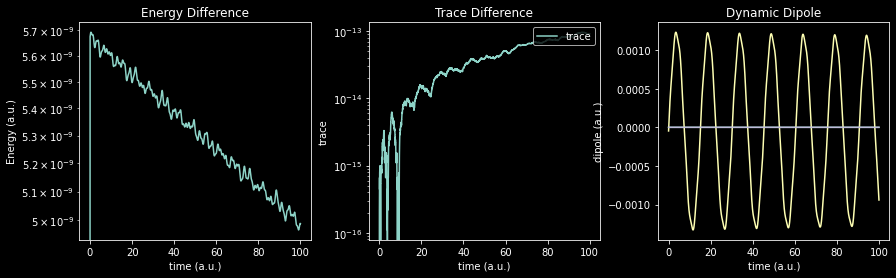

In [14]:
t = field3.t
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.subplots_adjust(hspace=0.01, wspace=0.25, right=2)

ax1.plot(t, np.abs(energy/energy[0]-1) )
ax1.set_yscale('log')
ax1.set_title("Energy Difference")
ax1.set(xlabel='time (a.u.)', ylabel='Energy (a.u.)')

ax2.plot(t, np.abs(trace/trace[0] -1), label="trace")
ax2.set_yscale('log')
ax2.legend(loc="upper right")
ax2.set_title("Trace Difference")
ax2.set(xlabel='time (a.u.)', ylabel='trace')

ax3.plot(t, d_tx.real )
ax3.set_title("Dynamic Dipole")
ax3.set(xlabel='time (a.u.)', ylabel='dipole (a.u.)')

fig.show()